In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import math
from statnight.parameters import POI
from statnight.hypothesis import Hypothesis
from statnight.hypotest import Discovery
from statnight.calculators import FrequentistCalculator
from statnight.config import Config

/Users/matthieumarinangeli/anaconda3/envs/tfn/lib/python3.6/site-packages/zfit-0.0.0-py3.6.egg/zfit/util/execution.py:53: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
import tensorflow as tf
import zfit
from zfit import ztf

## Signal + background fit:

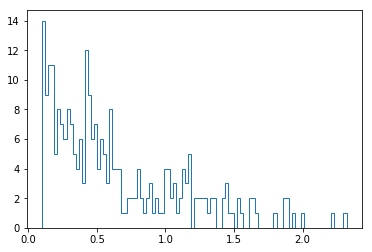

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 20)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

plt.hist(data, bins=100, histtype='step');

In [4]:
obs = zfit.Space('x', limits=bounds)

In [5]:
mean = zfit.Parameter("mean", 1.2, 0.1, 2., floating=False)
sigma = zfit.Parameter("sigma", 0.1, floating=False)
lambda_ = zfit.Parameter("lambda",-2.0, -5.0, -0.1)
Nsig = zfit.Parameter("Nsig", 20., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [6]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
background =  Nbkg * zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
tot_model = signal + background

In [7]:
# Create the negative log likelihood
from zfit.core.loss import ExtendedUnbinnedNLL, UnbinnedNLL
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_], fit_range=[obs]) 

In [9]:
# Load and instantiate a tensorflow minimizer
from zfit.minimizers.minimizer_minuit import MinuitMinimizer
minimizer = MinuitMinimizer()

In [10]:
# Create the minimization graph to minimize mu and sigma and run it (minimize does it directly)
minimum = minimizer.minimize(loss=nll)

FCN = -1122.2746876854276 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 3.7859386202704038e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda,-1.93492,0.140535,,,-5,-0.1,No
1,Nsig,14.6088,6.66669,,,-20,266,No
2,Nbkg,251.385,16.6969,,,0,292.6,No


In [11]:
def plotfitresult(pdf, bounds, nbins, data):
    x = np.linspace(*bounds, num=1000)
    pdf = zfit.run(tot_model.pdf(x, norm_range=bounds))
    _ = plt.plot(x, ((bounds[1] - bounds[0])/nbins)*(pdf), "-r")

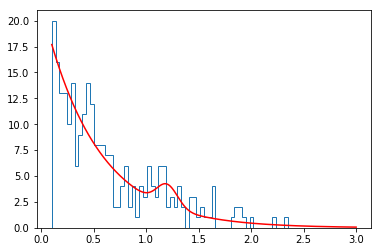

In [12]:
nbins = 80
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, data)

In [13]:
def profileLikelihood(loss, var, value):
    with var.set_value(value) as value:
        var.floating = False
        mini = minimizer
        mini.verbosity = 0
        minimum = mini.minimize(loss=loss)
    var.floating = True
    return minimum.fmin
    

In [14]:
nsig = np.linspace(5,50,30)
nll_ = np.empty(nsig.shape)

In [15]:
for i, n in np.ndenumerate(nsig):
    nll_[i] = profileLikelihood(nll, Nsig, n)
nll_ -= np.min(nll_)

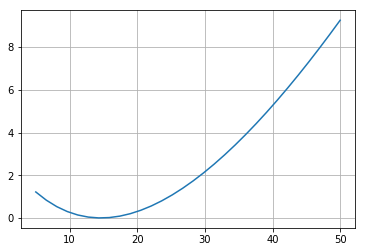

In [16]:
plt.plot(nsig, nll_)
plt.grid(True)

### Toys

In [17]:
def samplers(models, nsamples="extended"):
    fixed_params = [lambda_, Nbkg]
    samplers = [m.create_sampler(n=nsamples, fixed_params=fixed_params) for m in models]
    return samplers

## Discovery significance.

In [18]:
def lossbuilder(model, data, weights=None):
    loss = ExtendedUnbinnedNLL(model=model, data=data, fit_range=[obs]) 
    return loss
    
config = Config(tot_model, data_, lossbuilder, MinuitMinimizer(), profileLikelihood, samplers)

In [19]:
config.bestfit

Get fit best values!


FCN = -1122.274687478603 
 TOTAL NCALL = 71 
 NCALLS = 71 
 
 
 EDM = 3.99322314612529e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda,-1.93472,0.140523,,,-5,-0.1,No
1,Nsig,14.6135,6.66765,,,-20,266,No
2,Nbkg,251.342,16.6963,,,0,292.6,No


In [20]:
calc = FrequentistCalculator(config, ntoysnull=1000)

In [21]:
poinull = POI(Nsig, value=0)

In [22]:
discovery_test = Discovery(poinull, calc)

In [23]:
discovery_test.result();

Generating null hypothesis toys for POI('Nsig', value=0).
0 toys generated, fitted and scanned!
100 toys generated, fitted and scanned!
200 toys generated, fitted and scanned!
300 toys generated, fitted and scanned!
400 toys generated, fitted and scanned!
500 toys generated, fitted and scanned!
600 toys generated, fitted and scanned!
700 toys generated, fitted and scanned!
800 toys generated, fitted and scanned!
900 toys generated, fitted and scanned!
p_value for the Null hypothesis = 0.013
Significance = 2.2262117693171746


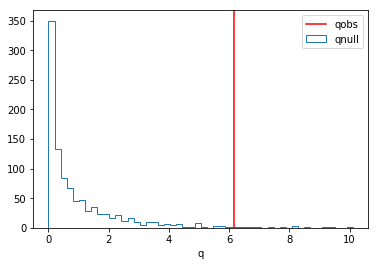

In [24]:
discovery_test.plot_qdist()